# 1. Introduction

This notebook focuses on evaluating the best-performing Vision Transformer (ViT) model derived from the ViT_Modeling_v5 notebook. The model employs a ViT-Base/16-384 architecture, trained from scratch but initialized with pretrained weights. Its input image size is 384×384, which results in longer prediction times compared to the models employing input images of 224x224 pixels (see notebook ViT_Modeling_v1.ipynb).

The following table summarizes the characteristics and the training parameters of the selected model.

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

# 2. Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import shutil
import torchvision

from torchvision.transforms import v2
from pathlib import Path

from modules.helper_functions import set_seeds, get_most_wrong_examples, load_model
from modules.dataloaders import create_dataloaders
from modules.engine import Engine

# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"
UNKNOWN_DIR_NAME = f"../data/food-101_100_percent_unknown_2"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Image size
IMG_SIZE = 384

# Manual transforms for the training dataset
manual_transforms = v2.Compose([           
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),    
])

# ViT-Base transforms
# Manual transforms for the training dataset
manual_transforms_train_vitb = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_test_vitb = v2.Compose([    
    v2.Resize((IMG_SIZE)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

In [4]:
# Create data loaders
_, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train_vitb,
    test_transform=manual_transforms_test_vitb,
    batch_size=BATCH_SIZE
)

# 3. Evaluating ViT-Base/16-384 with 102 Classes

The model will be evaluated using the test dataset with the following metrics: accuracy, loss, model size (MB), average prediction time per image (sec), and average predited images per second (frames/sec)

In [5]:
# Copy the unknown class into the dataset
shutil.copytree(UNKNOWN_DIR_NAME, TARGET_DIR_NAME, dirs_exist_ok=True)

'../data/food-101_100_percent'

In [6]:
# Load ViT-Base/16-384 
model_type="vitbase16_102_2025-01-27"
model_name = f"{model_type}"
vitbase16_model_name = model_name + "_epoch19.pth"
vitbase16_results_df = model_name + ".csv"

# Instantiate the model
vitbase16_model = torchvision.models.vit_b_16(image_size=IMG_SIZE).to(device)
vitbase16_model.heads = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)

vitbase16_model = torch.compile(vitbase16_model, backend="aot_eager")

# Load the trained weights
vitbase16_model = load_model(model=vitbase16_model,
                             model_weights_dir=model_dir,
                             model_weights_name=vitbase16_model_name)

# Load the training results
vitbase16_results = pd.read_csv(os.path.join(model_dir, vitbase16_results_df))

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[INFO] Loading model from: ..\models\vitbase16_102_2025-01-27_epoch19.pth


## 3.1 Making Predictions on the CPU: Intel Core i9-9900K@3.60GHz

In [7]:
# Make predictions on the CPU to compute the average prediction time per image
pred_list_cpu, classif_report_cpu = Engine(
    model=vitbase16_model,
    device="cpu"
    ).predict_and_store(
        test_dir=TEST_DIR,
        transform=manual_transforms_test_vitb,
        class_names=class_names,
        sample_fraction=1,
        seed=SEED) # make predictions on CPU

[INFO] Finding all filepaths ending with '.jpg' in directory: ..\data\food-101_100_percent\test


  0%|          | 0/25401 [00:00<?, ?it/s]

## 3.2 Making Predictions on the GPU: NVIDIA GeForce RTX 4070

In [8]:
# Make predictions on the GPU to compute the average prediction time per image
pred_list_gpu, classif_report_gpu = Engine(
    model=vitbase16_model,
    device=device
    ).predict_and_store(
        test_dir=TEST_DIR,
        transform=manual_transforms_test_vitb,
        class_names=class_names,
        sample_fraction=1,
        seed=SEED) # make predictions on GPU

[INFO] Finding all filepaths ending with '.jpg' in directory: ..\data\food-101_100_percent\test


  0%|          | 0/25401 [00:00<?, ?it/s]

## 3.3. Collecting Data

In [9]:
# Create a dictionary with the results for this model, in terms 
effnetb2_dict = {}
effnetb2_dict['Model Name'] = model_name
effnetb2_dict['Test Acc'] = round(vitbase16_results['test_acc'].iloc[-1], 4)
effnetb2_dict['Test los'] = round(vitbase16_results['test_loss'].iloc[-1], 4)
effnetb2_dict['Model Size [MB]'] = round(Path(os.path.join(model_dir, vitbase16_model_name)).stat().st_size // (1024*1024), 4)
effnetb2_dict['No Params [Million]'] = round(sum(p.numel() for p in vitbase16_model.parameters()) / 1000000, 4)
effnetb2_dict['CPU: Prediction Time - Mean [s]'] = round(pd.DataFrame(pred_list_cpu)['time_for_pred'].mean(), 4)
effnetb2_dict['CPU: Predicted Images per Sec [fps]'] = round(1.0 / effnetb2_dict['CPU: Prediction Time - Mean [s]'], 4)
effnetb2_dict['GPU: Prediction Time - Mean [s]'] = round(pd.DataFrame(pred_list_gpu)['time_for_pred'].mean(), 4)
effnetb2_dict['GPU: Predicted Images per Sec [fps]'] = round(1.0 / effnetb2_dict['GPU: Prediction Time - Mean [s]'], 4)

# Convert to dataframe
df_effnetb2 = pd.DataFrame.from_dict(effnetb2_dict, orient="index").reset_index()
df_effnetb2.columns = ['Metric', 'Value']
df_effnetb2

,Metric,Value
0,Model Name,vitbase16_102_2025-01-27
1,Test Acc,0.9276
2,Test los,1.0255
3,Model Size [MB],328
4,No Params [Million],86.1689
5,CPU: Prediction Time - Mean [s],0.3285
6,CPU: Predicted Images per Sec [fps],3.0441
7,GPU: Prediction Time - Mean [s],0.025
8,GPU: Predicted Images per Sec [fps],40.0


# 4. Identifying the Worst Performing Classes

In [10]:
# Identify the worst-performing classes based on F1-score
df_metrics = pd.DataFrame(classif_report_cpu).transpose()
df_metrics = df_metrics.iloc[:-3]
df_metrics = df_metrics.iloc[:,0:3]

# Determine the worst-performing classes on the f1-score
df_worst_class = df_metrics.sort_values(by='f1-score', ascending=True).reset_index()
df_worst_class.columns = ['Class', 'Precision', "Recall", "F1-Score"]
df_worst_class.head(5)

,Class,Precision,Recall,F1-Score
0,steak,0.677165,0.688,0.682540
1,filet_mignon,0.796680,0.768,0.782077
2,chocolate_mousse,0.773946,0.808,0.790607
3,chocolate_cake,0.803150,0.816,0.809524
4,pork_chop,0.838983,0.792,0.814815


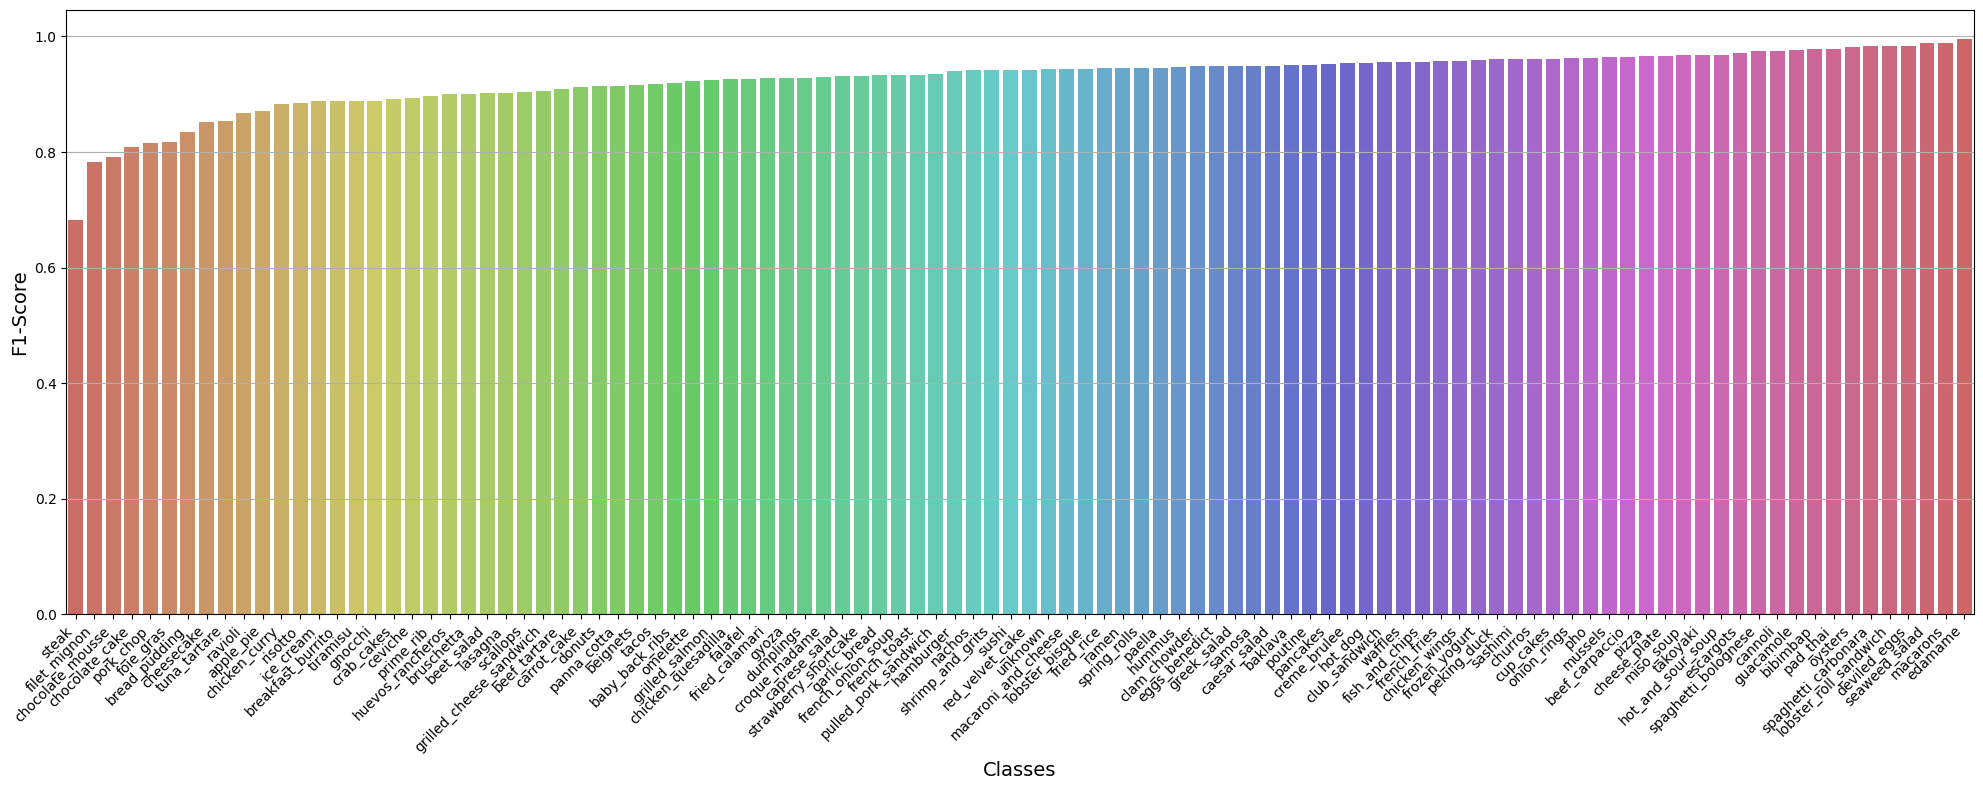

In [11]:
# Create a barplot for F1-scores
plt.figure(figsize=(20, 8))
sns.barplot(
    data=df_worst_class,
    x="Class",
    y="F1-Score",
    hue="Class",
    palette="hls",
    dodge=False,
    legend=False,
)

# Add labels and title
#plt.title("F1-Score of Classes", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha="right", fontsize=10)

# Improve layout
plt.tight_layout()
plt.grid(visible=True, which="both", axis="y")

# Save picture
plt.savefig(os.path.join('../images', f'f1-score_vs_food-type_vit_model_5.png'), dpi=600)

# Show picture
plt.show()

In [12]:
print(f"Average F1-Score: {round(df_worst_class['F1-Score'].mean(),2)}")

Average F1-Score: 0.93


As can be observed in the above table and figure, the worst performing class is "steak", which obtains an F1-Score of `66.5%` on the test set. In contrast, the best performing class is "edamame", with an F1-Score of almost `100%`. The average F1-Score is `92%`, showcasing a higher accuracy in distinguishing categories than the ViT-base-patch16-224 model.

In [13]:
df_top_wrong = get_most_wrong_examples(
    model=vitbase16_model,
    test_dataloader=test_dataloader_vit,
    num_samples=25,
    plot_images=True,
    n_cols=5,
    title_font_size=14,
    device=device
    )

Making predictions:   0%|          | 0/397 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 41, in do_one_step
    data = pin_memory(data, device)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 98, in pin_memory
    clone[i] = pin_memory(item, device)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 64, in pin_memory
    return data.pin_memory(device)
           ^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

